# Prototype Hyperspecctral Class

In [2]:
import glob, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from PIL import Image 

## Module

#### Metadata

In [3]:
def datastore_metadata( path_to_images ):
    """Prepare metadata on datastore"""
    image_map_files = []
    for file in os.listdir( path_to_images ):
        if file.endswith( ".png" ):
            image_map_files.append(file)
    df = pd.DataFrame(image_map_files, columns=["filename"])

    identifiers = parse_identifier( df )

    depths = parse_depths( df )

    image_metadata = pd.concat([df, identifiers, depths], axis=1)

    image_metadata = image_metadata\
        .sort_values(by="box-id")\
        .reset_index( drop=True )
    return image_metadata


def parse_identifier(df):
    """Parse identifier string in mineralmap and mask filenames"""
    identifiers = df["filename"]\
        .str.extract("CMM-(.*)@",expand=False)\
        .str.split("_", expand=True)\
        .astype("int")
    identifiers.columns = ["core-id", "box-id"] 
    return identifiers


def parse_depths(df):
    """Parse depth string in mineralmap and mask filenames"""
    depths = df["filename"]\
        .str.extract("@(.*).png",expand=False)\
        .str.split("_", expand=True)\
        .astype("float")
    depths.columns = ["depth-start", "depth-end"] 
    return depths 

#### Datastore I/O

In [20]:
def read_images(path_to_images, image_names, mode="sample"):
    """Read images into an ndarray array"""

    if mode == "sample":
     n = 5
    elif mode == "all":
        n = len(image_names)
    else:
        raise Exception("Unknown mode selection. Select sample or all.")
    images = [None] * n
    for i in range(0,n):
        images[i] = np.array( 
            Image.open( os.path.join(path_to_images,  image_names[i]) ) 
            )  
    return images


def read_datastore( path_to_images, mode="sample"):
    """Read image datastore"""

    image_metadata = datastore_metadata( path_to_images )
    image_names = image_metadata["filename"]
    images = read_images(path_to_images, image_names, mode="sample")

    return images

### Mineral map calcs

In [63]:
def mask_image( image ):
    """Mask background pixels of minalyze map image"""
    mask = np.all(image == (0,0,0), axis=-1)
    image_masked = np.copy( image )
    image_masked[mask,:]= [255, 255, 255]

    #if preview:
    #    fig, ax  = plt.subplots(1,1, figsize=(8,8))
    #    ax.imshow(image_masked, interpolation="none");
    return image_masked 


def identify_box( mask ):
    """Identify core box columns as mask"""
    bg = np.sum(mask==False, axis=0) == mask.shape[0]
    core_column = label( np.invert(bg) )
    return core_column


def segment_box( box, compartment_mask ):
    """Segment core box""" 
    n_column = np.max( np.unique(compartment_mask) )
    n = n_column+1

    array = [None] * n_column
    for i in range(1,n):
            array[i-1] = box[:, compartment_mask==i]
    return array 


def get_core_pixel_counts( mask, core_compartment ):
    """Get core pixel count per row per compartment"""

    compartments = segment_box( mask, core_compartment )

    n_row = compartments[0].shape[0] 
    n_column = len(compartments)
    n = n_column

    column_pixel_counts = np.zeros( (n_row,n_column ) )
    for j in range(0,n):
        column_pixel_counts[:,j] = np.sum( compartments[j], axis=1 )
    column_pixel_counts[column_pixel_counts==0] = np.nan
    return column_pixel_counts


def get_mineral_pixel_counts( image, mask, mineral_dictionary ):
    """Get all mineral pixel counts per row per compartment"""

    # segment core box mask into columns / compartments 
    core_compartments = identify_box( mask )

    # core pixel counts by row/compartment
    column_pixel_counts = get_core_pixel_counts( mask, core_compartments )

    # define tensor dimensions 
    n_row     = mask.shape[0] 
    n_column  = get_compartment_count( core_compartments )
    n_mineral = len( mineral_dictionary )
    n = n_column

    mineral_pixel_counts = np.zeros( (n_row, n_column, n_mineral) )

    #loop over minerals and core compartments 
    for k, (key,value) in enumerate( mineral_dictionary.items() ):
        mineral = np.all(image == value, axis=-1)
        compartments = segment_box( mineral, core_compartments )
        for j in range(0, n):
            mineral_pixel_counts[:,j,k] = np.sum(compartments[j],axis=1)
    return mineral_pixel_counts


def get_mineral_pixel_prc( mineral_pixel_counts, core_pixel_counts ):
    """Get all mineral pixel percentage per row per compartment"""
    mineral_pixel_prc = mineral_pixel_counts / core_pixel_counts[:,:, np.newaxis]
    return mineral_pixel_prc


def tensor_to_matrix(mineral_tensor):
    """Convert mineral tensor to a mineral matrix"""
    mineral_matrix = np.concatenate( mineral_tensor.transpose(1,0,2), axis=0)
    return mineral_matrix  

def get_compartment_count( compartment_mask ):
    """Number of core columns/compartments"""
    n_compartment = np.max( np.unique( compartment_mask ) )
    return n_compartment


### Class

In [64]:
class HyperspecDatastore:
    """Import hyperspectral from datastore"""
    def __init__(self, path_to_mineral, path_to_mask ):
        """ImportHyperspec constructor"""
        self.active_index = 1 
        self.core_box_df = []
        self.minerals = []
        self.masks = []
        self.metadata = []
        self.minerals_dictionary = []
        self.minerals_colormap = []
        self.path_to_mineral = path_to_mineral
        self.path_to_mask = path_to_mask
        
    def read_metadata(self):
        """Read metadata"""
        mineralmap_metadata = datastore_metadata( self.path_to_mineral )
        mask_metadata = datastore_metadata( self.path_to_mask )

        mineralmap_metadata = mineralmap_metadata.rename(columns={
            "filename": "mineral_filename",
            })
        mask_metadata = mask_metadata.rename(columns={
            "filename": "mask_filename",
            })

        joining_variables = ["core-id", "box-id", "depth-start", "depth-end"]
        metadata = mineralmap_metadata.merge(mask_metadata,
            how = "inner", 
            left_on = joining_variables,
            right_on = joining_variables)

        this = metadata.pop( "mineral_filename" )
        metadata.insert(metadata.columns.get_loc("mask_filename"), 
            "mineral_filename", this)

        self.metadata = metadata

    def read_legend(self):
        """Read legend containing mineral map color scheme."""
        legend = np.array( 
            Image.open( os.path.join(self.path_to_mineral, ".." ,  "mineral-legend.png") ) 
            )
        points_to_sample =np.array([
            [17,86],
            [17, 112],
            [17,136],
            [17,158],
            [17,184],
            [17,209],
            [17,235],
            ])
        mineral_keys = [
            "illite",
            "illite-smectite",
            "low-reflectance",
            "montmorillonite",
            "other",
            "smectite-kaolinite",
            "smectite-saponite",
            ]

        pixel_values = []
        pixel_values_scaled = [] 
        for row in points_to_sample:
            value = legend[row[1],row[0]][:3]
            pixel_values.append( tuple(value) )
            pixel_values_scaled.append( tuple(value/255) )
        pixel_values
        mineral_categories = dict( zip(mineral_keys, pixel_values) )
        self.minerals_dictionary = mineral_categories
        self.minerals_colomap = pixel_values_scaled

    def read(self, mode="sample"):
        """Read datastore"""

        #read/construct metadata
        self.read_metadata()

        #read mineralmap color scheme
        self.read_legend()

        #read minerals
        image_names = self.metadata["mineral_filename"]
        self.minerals = read_images(self.path_to_mineral, image_names )
        
        #read masks 
        image_names = self.metadata["mask_filename"]
        self.masks  = read_images(self.path_to_mask, image_names )


    def calculate_metrics(self):
        """Calculate """
        mineral = mask_image( self.minerals[self.active_index] )
        mask    = self.masks[ self.active_index ]
        
        #identify core compartments
        core_compartments = identify_box( mask )

        #core pixel curve
        core_pixel_counts = get_core_pixel_counts( 
            mask, 
            core_compartments )

        #mineral pixel counts 
        mineral_pixel_counts = get_mineral_pixel_counts( 
            mineral, 
            mask, 
            self.minerals_dictionary)

        # mineral pixel prc
        mineral_pixel_prc = get_mineral_pixel_prc( 
            mineral_pixel_counts, 
            core_pixel_counts )

        # mineral metric curves
        mineral_metrics = tensor_to_matrix( mineral_pixel_prc )

        # create core_box
        df = pd.DataFrame( 
            mineral_metrics, 
            columns=self.minerals_dictionary.keys() )

        self.core_box_df = df

    def get_core_column(self):
        """"""

    def plot_core_box(self, ptype="minerals"):
        """Preview core box image array"""
        images = getattr(self, ptype)
        n = len(images)

        # truncate 
        if n>5:
            n=5
            images = images[:5]

        fig, ax  = plt.subplots(1,n, figsize=(18,12))
        for item,image in zip(ax,images):
            item.imshow(image, interpolation="none")


    def plot_box_curves( self ):
        """Plot mineral curves"""
        n_element = self.core_box_df.shape[1]
        n_pixel   = self.core_box_df.shape[0]
        pixel_depth = np.arange(0,n_pixel)

        mineral_keys = self.minerals_dictionary.keys()

        fig, ax = plt.subplots(1,n_element, figsize=(18,12), sharey=True)
        for i in range( len(ax) ):
            mineral = self.core_box_df.iloc[:,i]
            ax[i].plot(mineral, pixel_depth)
            ax[i].set_title(mineral_keys[i])
        ax[0].invert_yaxis()
        ax[0].set_ylabel( "pixel depth" )
        return ax


    @classmethod
    def read_ds( cls, path_to_mineral, path_to_mask ):
        """Read hyperspectral datastore"""
        ds = cls(path_to_mineral, path_to_mask)
        ds.read()
        return ds


## Configure

In [58]:
path_to_data    = "../../data/cmm-111C-coremask-mineralmap/"
path_to_mineral = os.path.join(path_to_data, "borehole-mineral-map")
path_to_mask    = os.path.join(path_to_data, "core-mask")


## Import 

In [65]:
ds = HyperspecDatastore.read_ds(path_to_mineral, path_to_mask)

In [60]:
ds.metadata

,core-id,box-id,depth-start,depth-end,mineral_filename,mask_filename
0,111,1,0.0,10.0,Borehole_Mineral_MAP__VN-SWIR__CMM-111_1@0_10.png,Core_Mask__VN-SWIR__CMM-111_1@0_10.png
1,111,2,10.0,19.5,Borehole_Mineral_MAP__VN-SWIR__CMM-111_2@10_19...,Core_Mask__VN-SWIR__CMM-111_2@10_19.5.png
2,111,3,19.5,28.5,Borehole_Mineral_MAP__VN-SWIR__CMM-111_3@19.5_...,Core_Mask__VN-SWIR__CMM-111_3@19.5_28.5.png
3,111,4,28.5,37.5,Borehole_Mineral_MAP__VN-SWIR__CMM-111_4@28.5_...,Core_Mask__VN-SWIR__CMM-111_4@28.5_37.5.png
4,111,5,37.5,47.5,Borehole_Mineral_MAP__VN-SWIR__CMM-111_5@37.5_...,Core_Mask__VN-SWIR__CMM-111_5@37.5_47.5.png
...,...,...,...,...,...,...
233,111,234,2056.0,2064.0,Borehole_Mineral_MAP__VN-SWIR__CMM-111_234@205...,Core_Mask__VN-SWIR__CMM-111_234@2056_2064.png
234,111,235,2064.0,2074.5,Borehole_Mineral_MAP__VN-SWIR__CMM-111_235@206...,Core_Mask__VN-SWIR__CMM-111_235@2064_2074.5.png
235,111,236,2074.5,2081.5,Borehole_Mineral_MAP__VN-SWIR__CMM-111_236@207...,Core_Mask__VN-SWIR__CMM-111_236@2074.5_2081.5.png
236,111,237,2081.5,2090.0,Borehole_Mineral_MAP__VN-SWIR__CMM-111_237@208...,Core_Mask__VN-SWIR__CMM-111_237@2081.5_2090.png


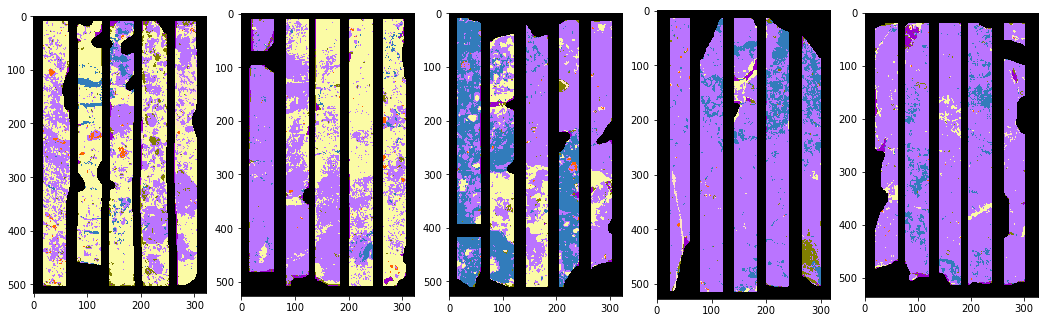

In [61]:
ds.plot_core_box(ptype="minerals")

In [66]:
ds.calculate_metrics()

In [68]:
ds.core_box_df.head(100)

,illite,illite-smectite,low-reflectance,montmorillonite,other,smectite-kaolinite,smectite-saponite
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
95,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,0.0,0.0,0.230769,0.769231,0.0,0.0,0.000000
98,0.0,0.0,0.076923,0.846154,0.0,0.0,0.076923
